In [10]:
# Initialize OK
from client.api.notebook import Notebook
ok = Notebook('hw09.ok')

Assignment: Resampling and the Bootstrap
OK, version v1.12.5



# Homework 9: Bootstrap, Resampling, CLT

**Reading**: 
* [Estimation](https://www.inferentialthinking.com/chapters/13/estimation.html)
* [Why the mean matters](https://www.inferentialthinking.com/chapters/14/why-the-mean-matters.html)

Please complete this notebook by filling in the cells provided. Before you begin, execute the following cell to load the provided tests. Each time you start your server, you will need to execute this cell again to load the tests.

Homework 9 is due **Thursday, 4/9 at 11:59pm**. You will receive an early submission bonus point if you turn in your final submission by Wednesday, 4/8 at 11:59pm. Start early so that you can come to office hours if you're stuck. Check the website for the office hours schedule. Late work will not be accepted as per the [policies](http://data8.org/sp20/policies.html) of this course. 

Directly sharing answers is not okay, but discussing problems with the course staff or with other students is encouraged. Refer to the policies page to learn more about how to learn cooperatively.

For all problems that you must write our explanations and sentences for, you **must** provide your answer in the designated space. Moreover, throughout this homework and all future ones, please be sure to not re-assign variables throughout the notebook! For example, if you use `max_temperature` in your answer to one question, do not reassign it later on.

As usual, **run the cell below** to import modules and autograder tests.

In [11]:
# Run this cell to set up the notebook, but please don't change it.

# These lines import the Numpy and Datascience modules.
import numpy as np
from datascience import *

# These lines do some fancy plotting magic.
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
import warnings
warnings.simplefilter('ignore', FutureWarning)

# These lines load the tests.
from client.api.notebook import Notebook
ok = Notebook('hw09.ok')
_ = ok.submit()

Assignment: Resampling and the Bootstrap
OK, version v1.12.5



<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Saving notebook... Saved 'hw09.ipynb'.
Submit... 100% complete
Submission successful for user: wajakhan@berkeley.edu
URL: https://okpy.org/cal/data8/sp20/hw09/submissions/ngrYyp



## 1. Preliminaries
The British Royal Air Force wanted to know how many warplanes the Germans had (some number `N`, which is a *parameter*), and they needed to estimate that quantity knowing only a random sample of the planes' serial numbers (from 1 to `N`). We know that the German's warplanes are labeled consecutively from 1 to `N`, so `N` would be the total number of warplanes they have. 

We normally investigate the random variation among our estimates by simulating a sampling procedure from the population many times and computing estimates from each sample that we generate.  In real life, if the British Royal Air Force (RAF) had known what the population looked like, they would have known `N` and would not have had any reason to think about random sampling. However, they didn't know what the population looked like, so they couldn't have run the simulations that we normally do. 

Simulating a sampling procedure many times was a useful exercise in *understanding random variation* for an estimate, but it's not as useful as a tool for practical data analysis.

Let's flip that sampling idea on its head to make it practical. **Given *just* a random sample of serial numbers, we'll estimate `N`, and then we'll use simulation to find out how accurate our estimate probably is, without ever looking at the whole population.**  This is an example of *statistical inference*.

We (the RAF in World War II) want to know the number of warplanes fielded by the Germans.  That number is `N`.  The warplanes have serial numbers from 1 to `N`, so `N` is also equal to the largest serial number on any of the warplanes.

We only see a small number of serial numbers (assumed to be a random sample with replacement from among all the serial numbers), so we have to use estimation.

#### Question 1.1
Is `N` a population parameter or a statistic?  If we use our random sample to compute a number that is an estimate of `N`, is that a population parameter or a statistic?

Set `N` and `N_estimate` to either the string `"parameter"` or `"statistic"` to indicate whether each value is a parameter or a statistic.

<!--
BEGIN QUESTION
name: q1_1
-->

In [12]:
N = "parameter"
N_estimate = "statistic"

In [13]:
ok.grade("q1_1");

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Running tests

---------------------------------------------------------------------
Test summary
    Passed: 2
    Failed: 0
[ooooooooook] 100.0% passed



To make the situation realistic, we're going to hide the true number of warplanes from you.  You'll have access only to this random sample:

In [14]:
observations = Table.read_table("serial_numbers.csv")
num_observations = observations.num_rows
observations.show()

serial number
47
42
57
79
26
23
36
64
83
135


#### Question 1.2
The average of the sample is about half of `N`. So one way to estimate `N` is to take twice the mean of the serial numbers we see. Write a function that computes that statistic.  It should take as its argument an array of serial numbers and return twice their mean.  Call the function `mean_based_estimator`.  

After that, use the function and the `observations` table to compute an estimate of `N` called `mean_based_estimate`.

<!--
BEGIN QUESTION
name: q1_2
-->

In [15]:
def mean_based_estimator(nums):
    return np.average(nums)*2

mean_based_estimate =  mean_based_estimator(observations.column("serial number"))
mean_based_estimate

122.47058823529412

In [16]:
ok.grade("q1_2");

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Running tests

---------------------------------------------------------------------
Test summary
    Passed: 2
    Failed: 0
[ooooooooook] 100.0% passed



#### Question 1.3
We can also estimate `N` by using the biggest serial number in the sample.  Compute this value and give it the name `max_estimate`.

<!--
BEGIN QUESTION
name: q1_3
-->

In [17]:
max_estimate = max(observations.column(0))
max_estimate

135

In [18]:
ok.grade("q1_3");

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Running tests

---------------------------------------------------------------------
Test summary
    Passed: 2
    Failed: 0
[ooooooooook] 100.0% passed



#### Question 1.4
Let's take a look at the values of `max_estimate` and `mean_based_estimate` that we got for our dataset. Which of these values is closer to the true population maximum `N`? Based off of our estimators, can we give a lower bound for what `N` must be? In other words, is there a value that `N` must be greater than or equal to?

<!--
BEGIN QUESTION
name: q1_4
manual: true
-->
<!-- EXPORT TO PDF -->

The max_estimate is closwer to the true population maximum of N and our mean_based_estimate indicates that N is at least 135 and that is our lower bound.

We can't just confidently proclaim that `max_estimate` or `mean_based_estimate` is equal to `N`.  What if we're really far off?  We want to get a sense of the accuracy of our estimates.

## 2. Resampling
To do this, we'll use resampling.  That is, we won't exactly simulate the observations the RAF would have really seen.  Rather we sample from our current sample, or "resample."

Why does that make any sense?

When we try to find the value of a population parameter, we ideally would like to use the whole population. However, we often only have access to one sample and we must use that to estimate the parameter instead.

Here, we would like to use the population of serial numbers to draw more samples and run a simulation about estimates of `N`.  But we still only have our sample.  So, we **use our sample in place of the population** to run the simulation. We resample from our original sample with replacement as many times as there are elements in the original sample. This resampling technique is called *bootstrapping*. 

Note that in order for bootstrapping to work well, you must start with a large, random sample. Then the Law of Large Numbers says that with high probability, your sample is representative of the population.

#### Question 2.1
Write a function called `simulate_resample`. The function should take one argument `tbl`, which is a table like `observations`. The function should generate a resample from the observed serial numbers in `tbl`.

<!--
BEGIN QUESTION
name: q2_1
-->

In [19]:
def simulate_resample(tbl):
    return tbl.sample(tbl.num_rows)

simulate_resample(observations) # Don't delete this line

serial number
21
50
79
26
64
83
50
135
64
26


In [20]:
ok.grade("q2_1");

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Running tests

---------------------------------------------------------------------
Test summary
    Passed: 2
    Failed: 0
[ooooooooook] 100.0% passed



We'll use many resamples at once to see what estimates typically look like.  However, we don't often pay attention to single resamples, so it's easy to misunderstand them.  Let's first answer some questions about our resample.

#### Question 2.2
Which of the following statements are true?

1. The original sample can contain serial numbers that are not in the resample.
2. Because the sample size is small, the histogram of the resample might look very different from the histogram of the original sample.
3. The resample can contain serial numbers that are not in the original sample.
4. The original sample has exactly one copy of each serial number for every German plane.
5. The resample has either zero, one, or more than one copy of each serial number.
6. The resample has exactly the same sample size as the original sample.

Assign `true_statements` to an array of the number(s) corresponding to correct statements.

*Note:* The "original sample" refers to `observations`, and the "resample" refers the output of one call of `simulate_resample()`. 

<!--
BEGIN QUESTION
name: q2_2
-->

In [21]:
true_statements = make_array(1,2,5,6)

In [22]:
ok.grade("q2_2");

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Running tests

---------------------------------------------------------------------
Test summary
    Passed: 1
    Failed: 0
[ooooooooook] 100.0% passed



Now let's write a function to do many resamples at once.

#### Question 2.3
Write a function called `sample_estimates`.  It should take 3 arguments:
1. `serial_num_tbl`: A table from which the data should be sampled.  The table will look like `observations`. 
2. `statistic`: A *function* that takes in an array of serial numbers as its argument and computes a statistic from the array (i.e. returns a calculated number). 
3. `num_replications`: The number of simulations to perform.

*Hint: You should use the function `simulate_resample` which you defined in Question 2.1*

The function should simulate many samples **with replacement** from the given table. For each of those samples, it should compute the statistic on that sample. Then it should **return an array** containing each of those statistics.  The code below provides an example use of your function and describes how you can verify that you've written it correctly.

<!--
BEGIN QUESTION
name: q2_3
-->

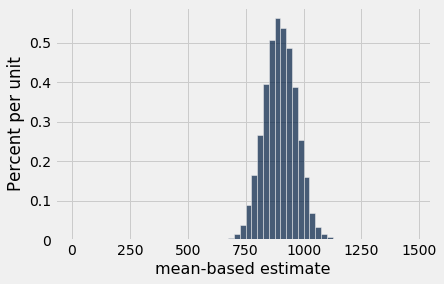

In [23]:
def sample_estimates(serial_num_tbl, statistic, num_replications):
    stats= make_array()
    for i in np.arange(num_replications):
        re_stats= statistic(simulate_resample(serial_num_tbl).column(0))
        stats= np.append(stats,re_stats)
    return stats

population = Table().with_column("serial number", np.arange(1, 1000+1))
one_sample = Table.read_table("one_sample.csv") #This is a sample from the population table
example_estimates = sample_estimates(
    one_sample,
    mean_based_estimator,
    10000)
Table().with_column("mean-based estimate", example_estimates).hist(bins=np.arange(0, 1500, 25))

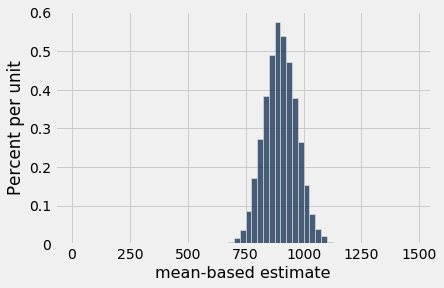

In [24]:
def sample_estimates(serial_num_tbl, statistic, num_replications):
    stats= make_array()
    for i in np.arange(num_replications):
        re_stats= statistic(simulate_resample(serial_num_tbl).column(0))
        stats= np.append(stats,re_stats)
    return stats

# DON'T CHANGE THE CODE BELOW THIS COMMENT! (If you do, you will fail the hidden test)
# This is just an example to test your function.
# This should generate an empirical histogram of twice-mean-based estimates
# of N from samples of size 50 if N is 1000.  This should be a bell-shaped
# curve centered at roughly 900 with most of its mass in [800, 1200].  To verify your
# answer, make sure that's what you see!
population = Table().with_column("serial number", np.arange(1, 1000+1))
one_sample = Table.read_table("one_sample.csv") #This is a sample from the population table
example_estimates = sample_estimates(
    one_sample,
    mean_based_estimator,
    10000)
Table().with_column("mean-based estimate", example_estimates).hist(bins=np.arange(0, 1500, 25))

In [25]:
ok.grade("q2_3");

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Running tests

---------------------------------------------------------------------
Test summary
    Passed: 3
    Failed: 0
[ooooooooook] 100.0% passed



Now we can go back to the sample we actually observed (the table `observations`) and estimate how much our mean-based estimate of `N` would have varied from sample to sample.

#### Question 2.4
Using the bootstrap and the sample `observations`, simulate the approximate distribution of *mean-based estimates* of `N`.  Use 7,500 replications and save the estimates in an array called `bootstrap_mean_based_estimates`.  

We have provided code that plots a histogram, allowing you to visualize the simulated estimates.

<!--
BEGIN QUESTION
name: q2_4
-->

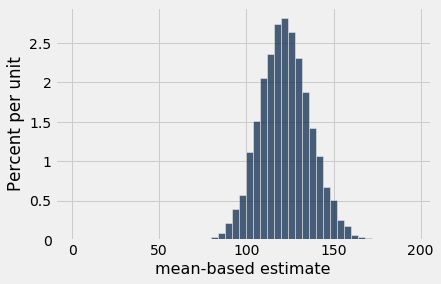

In [26]:
bootstrap_mean_based_estimates = make_array()
Obs_one= sample_estimates(observations,mean_based_estimator,7500)
bootstrap_mean_based_estimates= np.append(bootstrap_mean_based_estimates,Obs_one)

# Don't change the code below! This plots bootstrap_mean_based_estimates.
Table().with_column("mean-based estimate", bootstrap_mean_based_estimates).hist(bins=np.arange(0, 200, 4)) 

In [27]:
ok.grade("q2_4");

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Running tests

---------------------------------------------------------------------
Test summary
    Passed: 1
    Failed: 0
[ooooooooook] 100.0% passed



#### Question 2.5
Using the bootstrap and the sample `observations`, simulate the approximate distribution of *max estimates* of `N`.  Use 7,500 replications and save the estimates in an array called `bootstrap_max_estimates`.

We have provided code that plots a histogram, allowing you to visualize the simulated estimates.

<!--
BEGIN QUESTION
name: q2_5
-->

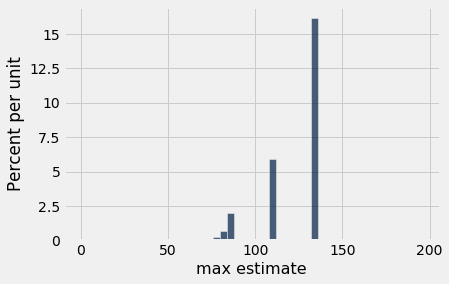

In [28]:
bootstrap_max_estimates = make_array()
Obs_one= sample_estimates(observations,max,7500)
bootstrap_max_estimates= np.append(bootstrap_max_estimates,Obs_one)

# Don't change the code below! This plots bootstrap_max_estimates.
Table().with_column("max estimate", bootstrap_max_estimates).hist(bins=np.arange(0, 200, 4)) 

In [29]:
ok.grade("q2_5");

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Running tests

---------------------------------------------------------------------
Test summary
    Passed: 1
    Failed: 0
[ooooooooook] 100.0% passed



#### Question 2.6
`N` was actually 150! Compare the histograms of estimates you generated in 2.4 and 2.5 and answer the following questions:

1. How does the distribution of values for the mean-based estimates differ from the max estimates? Do both distributions contain the true max value?
2. Which estimator is more dependent on the original random sample? Why so?

<!--
BEGIN QUESTION
name: q2_6
manual: true
-->
<!-- EXPORT TO PDF -->

1. The distribution of values for the mean-based estimates differ from the max estimates as the mean-based estimates has normal distribution histogram vs the max estimate which only has 5 bars on the histogram that were drawn from the max of random sample- but only the mean-based estimate contains the true max value.
2. The mean-based estimator is more dependent on the original random sample because it still had 150 which is the true max value versus the max estimates which didn't go above 135 as that was its max value so therefore the mean-based had values that contained 150 in them.

## 3. Computing intervals

#### Question 3.1
Compute an interval that covers the middle 95% of the mean-based bootstrap estimates.  Assign your values to `left_end_1` and `right_end_1`. 

*Hint:* Use the `percentile` function! Read up on its documentation [here](http://data8.org/sp19/python-reference.html).

Verify that your interval looks like it covers 95% of the area in the histogram. The red dot on the histogram is the value of the parameter (150).

<!--
BEGIN QUESTION
name: q3_1
-->

Middle 95% of bootstrap estimates: [94.705882, 151.529412]


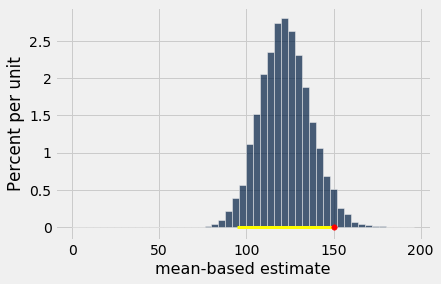

In [30]:
left_end_1 = percentile(2.5,bootstrap_mean_based_estimates)
right_end_1 = percentile(97.5,bootstrap_mean_based_estimates)
print("Middle 95% of bootstrap estimates: [{:f}, {:f}]".format(left_end_1, right_end_1))

# Don't change the code below! It draws your interval and N on the histogram of mean-based estimates.
Table().with_column("mean-based estimate", bootstrap_mean_based_estimates).hist(bins=np.arange(0, 200, 4)) 
plt.plot(make_array(left_end_1, right_end_1), make_array(0, 0), color='yellow', lw=3, zorder=1)
plt.scatter(150, 0, color='red', s=30, zorder=2);

In [31]:
ok.grade("q3_1");

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Running tests

---------------------------------------------------------------------
Test summary
    Passed: 1
    Failed: 0
[ooooooooook] 100.0% passed



#### Question 3.2
Write code that simulates the sampling and bootstrapping process again, as follows:

1. Generate a new set of random observations the RAF might have seen by sampling from the `population` table we have created for you below. Use the sample size `num_observations`.
2. Compute an estimate of `N` from these new observations, using `mean_based_estimator`.
3. Using only the new observations, compute 10,000 bootstrap estimates of `N`.
4. Plot these bootstrap estimates and compute an interval covering the middle 95%.

*Note:* Traditionally, when we bootstrap using a sample from the population, that sample is usually a simple random sample (i.e., sampled uniformly at random from the population without replacement). However, if the population size is big enough, the difference between sampling with replacement and without replacement is negligible. Think about why that's the case! This is why when we define `new_observations`, we sample with replacement.

<!--
BEGIN QUESTION
name: q3_2
-->

New mean-based estimate: 156.640000
Middle 95% of bootstrap estimates: [142.760000, 170.320000]


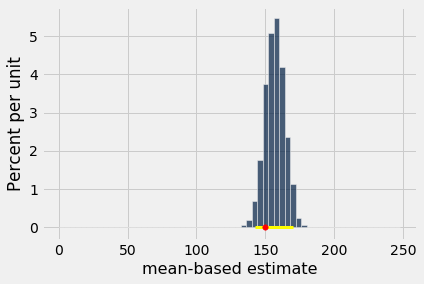

In [32]:
population = Table().with_column("serial number", np.arange(1, 150+1))

new_observations = population.sample(population.num_rows)
new_mean_based_estimate = mean_based_estimator(new_observations.column(0))
new_bootstrap_estimates = sample_estimates(new_observations,mean_based_estimator,10000)
Table().with_column("mean-based estimate", new_bootstrap_estimates).hist(bins=np.arange(0, 252, 4))
new_left_end = percentile(2.5,new_bootstrap_estimates)
new_right_end = percentile(97.5,new_bootstrap_estimates)

# Don't change code below this line!
print("New mean-based estimate: {:f}".format(new_mean_based_estimate))
print("Middle 95% of bootstrap estimates: [{:f}, {:f}]".format(new_left_end, new_right_end))

plt.plot(make_array(new_left_end, new_right_end), make_array(0, 0), color='yellow', lw=3, zorder=1)
plt.scatter(150, 0, color='red', s=30, zorder=2);

In [33]:
ok.grade("q3_2");

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Running tests

---------------------------------------------------------------------
Test summary
    Passed: 2
    Failed: 0
[ooooooooook] 100.0% passed



#### Question 3.3
Does the interval covering the middle 95% of the new bootstrap estimates include `N`?  If you ran that cell 100 times and generated 100 intervals, how many of those intervals would you expect to include `N`?

<!--
BEGIN QUESTION
name: q3_3
manual: true
-->
<!-- EXPORT TO PDF -->

You would expect 95 of them to include the N as its .95(confidence interval) times 100(times generated). N is 95 or contains 0.95 out of 1.


Let's look at what happens when we use a small number of resamples:

<img src="smallrephist.png" width="525"/>

This histogram and confidence interval was generated using 10 resamples of `new_observations`.

New mean-based estimate: 154.066667
Middle 95% of bootstrap estimates: [143.866667, 161.280000]


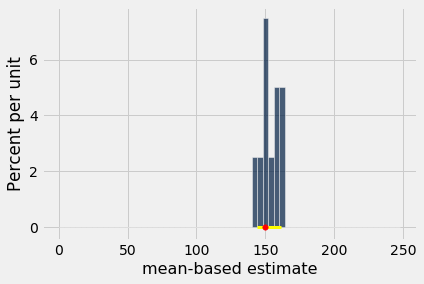

In [34]:
population = Table().with_column("serial number", np.arange(1, 150+1))

new_observations = population.sample(population.num_rows)
new_mean_based_estimate = mean_based_estimator(new_observations.column(0))
new_bootstrap_estimates = sample_estimates(new_observations,mean_based_estimator,10)
Table().with_column("mean-based estimate", new_bootstrap_estimates).hist(bins=np.arange(0, 252, 4))
new_left_end = percentile(2.5,new_bootstrap_estimates)
new_right_end = percentile(97.5,new_bootstrap_estimates)

# Don't change code below this line!
print("New mean-based estimate: {:f}".format(new_mean_based_estimate))
print("Middle 95% of bootstrap estimates: [{:f}, {:f}]".format(new_left_end, new_right_end))

plt.plot(make_array(new_left_end, new_right_end), make_array(0, 0), color='yellow', lw=3, zorder=1)
plt.scatter(150, 0, color='red', s=30, zorder=2);

#### Question 3.4
In the cell below, explain why this histogram and confidence interval look different from the ones you generated previously in Question 3.2 where the number of resamples was 10,000.

<!--
BEGIN QUESTION
name: q3_4
manual: true
-->
<!-- EXPORT TO PDF -->

It looks the way it does because the small number of resamples, for example it could of been due to random chance that it picked really high values and dived them (got big numbers such 150,140,145,150,150 ....) instead of smalls values or even balanaced out value of lower and higher but with 10000 you did it 10000 times which gives more numbers, but if you ran it 10 times maybe you get a New mean-based estimate that is really high like 177 or can be very low as 140 so thats why the histogram looks very different.

## 4. The CLT and Book Reviews

Your friend has recommended you a book, so you look for it on an online marketplace. You decide to look at reviews for the book just to be sure that it's worth buying. Let's say that on Amazon, the book only has 80% positive reviews. On GoodReads, it has 95% positive reviews. You decide to investigate a bit further by looking at the percentage of positive reviews for the book on 5 different websites that you know of, and you collect these positive review percentages in a table called `reviews.csv`.

Here, we've loaded in the table for you.

In [35]:
reviews = Table.read_table("reviews.csv") 
reviews

Positive Review Percentage
80
96
33
65
95


**Question 4.1**. Calculate the average percentage of positive reviews from your sample and assign it to `initial_sample_mean`.

<!--
BEGIN QUESTION
name: q4_1
manual: false
-->

In [36]:
initial_sample_mean = sum(reviews.column(0))/reviews.num_rows
initial_sample_mean

73.8

In [37]:
ok.grade("q4_1");

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Running tests

---------------------------------------------------------------------
Test summary
    Passed: 1
    Failed: 0
[ooooooooook] 100.0% passed



You've calculated the average percentage of positive reviews from your sample, so now you want to do some inference using this information. 

**Question 4.2**. First, simulate 5000 bootstrap resamples of the positive review percentages. For each bootstrap resample, calculate the resample mean and store the resampled means in an array called `resample_positive_percentages`. Then, plot a histogram of the resampled means.

<!--
BEGIN QUESTION
name: q4_2
manual: false
-->

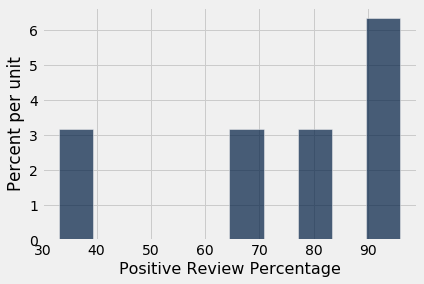

In [38]:
reviews.hist("Positive Review Percentage")

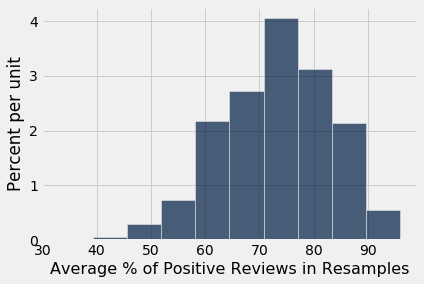

In [39]:
resample_positive_percentages = make_array()

for i in np.arange(5000):
    resample = reviews.sample()
    resample_avg_positive = sum(resample.column(0))/resample.num_rows
    resample_positive_percentages = np.append(resample_positive_percentages,resample_avg_positive)
    
# Do NOT change these lines.
(Table().with_column("Average % of Positive Reviews in Resamples", 
                     resample_positive_percentages).hist("Average % of Positive Reviews in Resamples"))

In [40]:
ok.grade("q4_2");

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Running tests

---------------------------------------------------------------------
Test summary
    Passed: 1
    Failed: 0
[ooooooooook] 100.0% passed



**Question 4.3**. What is the the shape of the empirical distribution of the average percentage of positive reviews based on our original sample? What value is the distribution centered at? Assign your answer to the variable `initial_sample_mean_distribution`--your answer should be either `1`, `2`, `3`, or `4` corresponding to the following choices:

*Hint: Look at the histogram you made in Question 2. Run the cell that generated the histogram a few times to check your intuition.*

1. The distribution is approximately normal because of the Central Limit Theorem, and it is centered at the original sample mean.
2. The distribution is not necessarily normal because the Central Limit Theorem may not apply, and it is centered at the original sample mean.
3. The distribution is approximately normal because of the Central Limit Theorem, but it is not centered at the original sample mean.
4. The distribution is not necessarily normal because the Central Limit Theorem may not apply, and it is not centered at the original sample mean.

<!--
BEGIN QUESTION
name: q4_3
manual: false
-->

In [41]:
initial_sample_mean_distribution = (2)

In [42]:
ok.grade("q4_3");

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Running tests

---------------------------------------------------------------------
Test summary
    Passed: 1
    Failed: 0
[ooooooooook] 100.0% passed



According to the Central Limit Theorem, the probability distribution of the sum or average of a *large random sample* drawn with replacement will be roughly normal, regardless of the distribution of the population from which the sample is drawn. 

**Question 4.4**. Note the statement about the sample being large and random. Is this sample large and random? Give a brief explanation.

*Note: The setup at the beginning of this exercise explains how the sample was gathered.*

<!--
BEGIN QUESTION
name: q4_4
manual: true
-->
<!-- EXPORT TO PDF -->

No the sample had only 5 values which isn't that large large would be 

Though you have an estimate of the true percentage of positive reviews (the sample mean), you want to measure how variable this estimate is. 

**Question 4.5**. Find the standard deviation of your resampled average positive review percentages, which you stored in `resample_positive_percentages`, and assign the result to the variable `resampled_means_variability`.

<!--
BEGIN QUESTION
name: q4_5
manual: false
-->

In [43]:
resampled_means_variability = np.std(resample_positive_percentages)
resampled_means_variability

10.444157403945999

In [44]:
ok.grade("q4_5");

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Running tests

---------------------------------------------------------------------
Test summary
    Passed: 1
    Failed: 0
[ooooooooook] 100.0% passed



This estimate is pretty variable! To make the estimate less variable, let's say you found a way to randomly sample reputable marketplaces from across the web which sell this book. Let's say that there are up to 150 of these marketplaces. The percentages of positive reviews are loaded into the table `more_reviews`.

In [45]:
# Just run this cell
more_reviews = Table.read_table("more_reviews.csv")
more_reviews

Positive Review Percentage
75
79
90
73
92
86
100
100
64
61


In the next few questions, we'll test an important result of the Central Limit Theorem. According to the CLT, the standard deviation of all possible sample means can be calculated using the following formula:

$$
\text{SD of all possible sample means} = \dfrac{\text{Population SD}}{\sqrt{\text{sample size}}}
$$

This formula gives us another way to approximate the SD of the sample means other than calculating it empirically. We can test how well this formula works by calculating the SD of sample means for different sample sizes.

The following code calculates the SD of sample means using the CLT and empirically for a range of sample sizes. Then, it plots a scatter plot comparing the SD of the sample means calculated with both methods. Each point corresponds to a different sample size. 

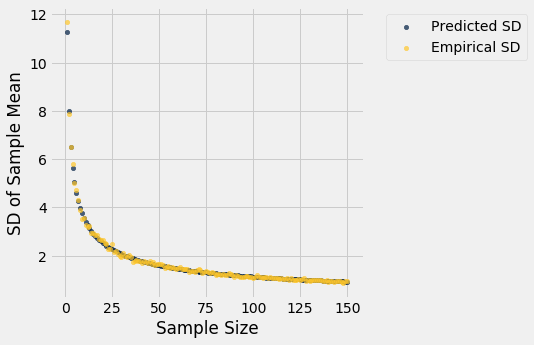

In [46]:
# Just run this cell. It's not necessary for you to read this code, but you can do 99% of this on your own!
# Note: this cell might take a bit to run.

def empirical_sample_mean_sd(n):
    sample_means = make_array()
    for i in np.arange(500):
        sample = more_reviews.sample(n).column('Positive Review Percentage') 
        sample_mean = np.mean(sample) 
        sample_means = np.append(sample_means, sample_mean) 
    return np.std(sample_means)

def predict_sample_mean_sd(n):
    return np.std(more_reviews.column(0)) / (n**0.5)

sd_table = Table().with_column('Sample Size', np.arange(1,151))
predicted = sd_table.apply(predict_sample_mean_sd, 'Sample Size')
empirical = sd_table.apply(empirical_sample_mean_sd, 'Sample Size')
sd_table = sd_table.with_columns('Predicted SD', predicted, 'Empirical SD', empirical)
sd_table.scatter('Sample Size')
plt.ylabel("SD of Sample Mean");

**Question 4.6**. Assign the numbers corresponding to all true statements to an array called `sample_mean_sd_statements`. 

1. The law of large numbers tells us that the distribution of a large random sample should resemble the distribution from which it is drawn.
2. The SD of the sample means is proportional to the square root of the sample size. 
3. The SD of the sample means is proportional to 1 divided by the square root of the sample size. 
4. The law of large numbers guarantees that empirical and predicted sample mean SDs will be exactly equal to each other when the sample size is large.
5. The law of large numbers guarantees that empirical and predicted sample mean SDs will be approximately equal to each other when the sample size is large.
6. The plot above shows that as our sample size increases, our estimate for the true percentage of positive reviews becomes more accurate.
7. The plot above shows that the size of the population affects the SD of the sample means.

<!--
BEGIN QUESTION
name: q4_6
manual: false
-->

In [47]:
sample_mean_sd_statements = make_array(1,3,5,6)

In [48]:
ok.grade("q4_6");

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Running tests

---------------------------------------------------------------------
Test summary
    Passed: 1
    Failed: 0
[ooooooooook] 100.0% passed



Often times, when conducting statistical inference, you'll want your estimate of a population parameter to have a certain accuracy. It is common to measure accuracy of an estimate using the SD of the estimate--as the SD goes down, your estimate becomes less variable. As a result, the width of the confidence interval for your estimate decreases (think about why this is true). We know from the Central Limit Theorem that when we estimate a sample mean, the SD of the sample mean decreases as the sample size increases (again, think about why this is true).  

**Question 4.7**. Imagine you are asked to estimate the true average percentage of positive reviews for this book and you have not yet taken a sample of review websites. Which of these is the best way to decide how large your sample should be to achieve a certain level of accuracy for your estimate of the true average percentage of positive reviews? Assign `sample_size_calculation` to either `1`, `2`, or `3` corresponding to the statements below.

*Note: Assume you know the population SD or can estimate it with reasonable accuracy.*
1. Take many random samples of different sizes, then calculate empirical confidence intervals using the bootstrap until you reach your desired accuracy. 
2. Use the Central Limit Theorem to calculate what sample size you need in advance. 
3. Randomly pick a sample size and hope for the best.

<!--
BEGIN QUESTION
name: q4_7
manual: false
-->

In [49]:
sample_size_calculation = 2

In [50]:
ok.grade("q4_7");

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Running tests

---------------------------------------------------------------------
Test summary
    Passed: 1
    Failed: 0
[ooooooooook] 100.0% passed



Congratulations, you're done with Homework 9! Be sure to run the cells below to submit your assignment.

In [51]:
# For your convenience, you can run this cell to run all the tests at once!
import os
print("Running all tests...")
_ = [ok.grade(q[:-3]) for q in os.listdir("tests") if q.startswith('q') and len(q) <= 10]
print("Finished running all tests.")

Running all tests...
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Running tests

---------------------------------------------------------------------
Test summary
    Passed: 1
    Failed: 0
[ooooooooook] 100.0% passed

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Running tests

---------------------------------------------------------------------
Test summary
    Passed: 1
    Failed: 0
[ooooooooook] 100.0% passed

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Running tests

---------------------------------------------------------------------
Test summary
    Passed: 1
    Failed: 0
[ooooooooook] 100.0% passed

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Running tests

---------------------------------------------------------------------
Test summary
    Passed: 2
    Failed: 0
[ooooooooook] 100.0% passed

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Running t

In [52]:
_ = ok.submit()

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Saving notebook... Saved 'hw09.ipynb'.
Submit... 100% complete
Submission successful for user: wajakhan@berkeley.edu
URL: https://okpy.org/cal/data8/sp20/hw09/submissions/GM5Yl5

